In [1]:
import cv2
import numpy as np
import tifffile
import zarr
import matplotlib.pyplot as plt
import json
import math

In [2]:
from colour_lib.palette_parser import (
    ImageProcessing,
    ImageAlignment,
    ObjectDetection,
    ObjectColor,
)

img_processor = ImageProcessing.ImageProcessing()
img_aligner = ImageAlignment.ImageAlignment()
obj_detector = ObjectDetection.ObjectDetection()
obj_color_extractor = ObjectColor.ObjectColor()

### **zarr_storage**

In [3]:
tiff_storage = tifffile.imread(
    "/uftp/src/palettes/IHCjul23_020723_2.ome.tiff", aszarr=True
)
zarr_storage = zarr.open(tiff_storage, mode="r")

zarr_light = zarr_storage[len(zarr_storage) - 2]

### **odl**

In [ ]:
odl = np.array(zarr_light)
h, w = odl.shape[:2]

check if rectangles could be detected. its helps to decide if we need sharp the image. also rectangles will be used as patterns for odl alignment

In [6]:
image = odl
image_processed = img_processor.gray_blur_thresh(image=image)
rect_coordinates, rect_image_to_show = obj_detector.find_rectangles(
    image_to_find=image_processed, show_image=True, image_to_show=odl
)
print(rect_coordinates)

{'rect_CA': {'y0': 2417, 'y1': 3013, 'x0': 251, 'x1': 2528}, 'rect_1000': {'y0': 4250, 'y1': 5472, 'x0': 1738, 'x1': 2424}, 'rect_750': {'y0': 4556, 'y1': 5473, 'x0': 956, 'x1': 1469}, 'rect_500': {'y0': 4865, 'y1': 5476, 'x0': 356, 'x1': 698}, 'rect_400': {'y0': 3581, 'y1': 4069, 'x0': 316, 'x1': 589}, 'rect_300': {'y0': 3591, 'y1': 3954, 'x0': 950, 'x1': 1151}}


### odl >> **odl_aligned** (obj detection)

aligned odl will be used for rectangles and circles detection

In [7]:
flipped_image = img_aligner.flip(image_to_flip=odl, pattern=rect_coordinates)
rotated_image, rot_image_to_show = img_aligner.rotate(
    image_to_rotate=flipped_image, show_image=True, image_to_show=flipped_image
)
odl_aligned = rotated_image

rectangle coordinates

In [ ]:
image = odl_aligned
image_processed = img_processor.gray_blur_thresh(image=image)
rect_coordinates, _ = obj_detector.find_rectangles(
    image_to_find=image_processed, show_image=True, image_to_show=image
)

circle coordinates

In [9]:
circ_coordinates = {}
rect_coordinates_with_circles = [key for key in rect_coordinates if "CA" not in key]

for rect_name in rect_coordinates_with_circles:

    coords = rect_coordinates[rect_name]
    crop = np.array(odl_aligned)[
        coords["y0"] : coords["y1"], coords["x0"] : coords["x1"]
    ]

    crop_sobel = img_processor.sobel(image=crop)
    crop_clahe = img_processor.clahe(crop_sobel)
    crop_clahe = img_processor.clahe(crop_clahe)
    crop_general = img_processor.gray_blur_canny(crop_clahe)
    crop_circ_coordinates = obj_detector.find_circles(
        crop_general, averaging_threshold=10
    )
    crop_circ_coordinates = obj_detector.circles_coordinates_as_dictionary(
        crop_circ_coordinates, rect_name=rect_name[4:]
    )

    for key, value in crop_circ_coordinates.items():
        if "x_centroid" in value:
            value["x_centroid"] += coords["x0"]
            value["y_centroid"] += coords["y0"]

    circ_coordinates.update(crop_circ_coordinates)

### **zarr_light/odl** << odl_aligned

lets find rectangle and circle coordinates on non-aligned odl/zarr_light

In [ ]:
rect_coordinates_light = img_aligner.give_original_coordinates(
    rect_coordinates, w=w, h=h, type="rectangle"
)
circle_coordinates_light = img_aligner.give_original_coordinates(
    circ_coordinates, w=w, h=h, type="circle"
)
obj_coordinates_light = {**rect_coordinates_light, **circle_coordinates_light}

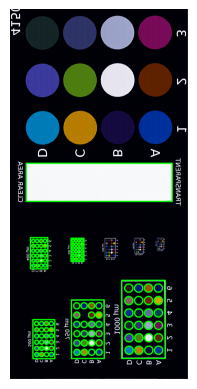

In [11]:
image = odl.copy()
obj_detector.draw_rectangles(image, rect_coordinates_light)
obj_detector.draw_circles(image, circle_coordinates_light)
plt.imshow(image)
plt.axis("off")
plt.show()

### **zarr_scaled** << zarr_light/odl

In [13]:
zarr_scaled = zarr_storage[1]
obj_coordinates_scaled = obj_detector.scale(
    zarr_scaled, zarr_light, obj_coordinates_light
)

lets find mean rgb value

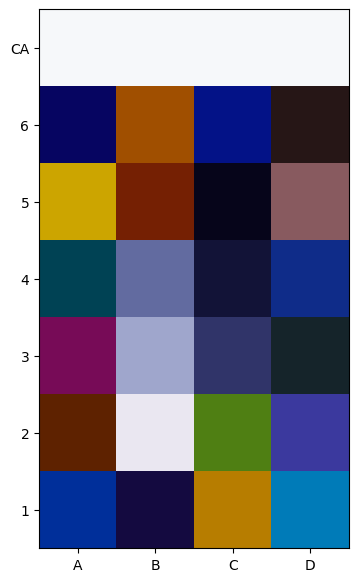

In [5]:
obj_rgb = obj_color_extractor.calculate_rgb(obj_coordinates_scaled, zarr_scaled)
obj_color_extractor.plot_palette(obj_rgb)

save

In [17]:
with open("palette_obj_rgb/IHCjul23_020723_2.ome.tiff.json", "w") as json_file:
    json.dump(obj_rgb, json_file)
with open(
    "palette_obj_coordinates/IHCjul23_020723_2.ome.tiff_layer1.json", "w"
) as json_file:
    json.dump(obj_coordinates_scaled, json_file)

download

In [18]:
with open("palette_obj_rgb/IHCjul23_020723_2.ome.tiff.json", "r") as json_file:
    obj_rgb = json.load(json_file)
with open(
    "palette_obj_coordinates/IHCjul23_020723_2.ome.tiff_layer1.json", "r"
) as json_file:
    obj_coordinates_scaled = json.load(json_file)